## Notebook to create a worldfloods dataloader

In [49]:
import sys, os
from pathlib import Path
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1: Setup Configuration file

In [26]:
from src.models.utils.configuration import AttrDict
from src.data.worldfloods.configs import CHANNELS_CONFIGURATIONS

opt = {
    "data_params": {
        "bucket_id": "ml4floods",
        "path_to_splits": "worldfloods/public",
        "input_folder": "S2",
        "target_folder": "gt",
        "batch_size": 8,
        "window_size": [256, 256],
        "bands": "all",
        "train_transformation": {
            "num_classes": 3,
            "resizefactor": {
                "downsampling_factor": 3,
                "p": 1.0
            },
            "normalize": True,
            "shiftscalerotate": {
                "shift_limit": 0.001,
                "scale_limit": 0.01,
                "rotate_limit": 0.01,
                "p": 0.5
            },
            "gaussnoise": {
                "var_limit_lower": 1e-6,
                "var_limit_upper": 1e-3,
                "p": 0.2
            },
            "motionblur": {
                "blur_limit": 7,
                "always_apply": False
            },
            "totensor": True,
            "use_channels": "all"
        },
        "test_transformation": {
            "num_classes": 3,
            "resizefactor": None,
            "shiftscalerotate": None,
            "gaussnoise": None,
            "motionblur": None,
            "totensor": True,
            "use_channels": "all",
            "normalize": True
        }
    }
}
opt = AttrDict.from_nested_dicts(opt)

### Step 2: Setup Transformations

In [89]:
# ### Option 1: generate from config
# from src.preprocess.transformations import transforms_generator

# train_transform = transforms_generator(opt.data_params.train_transformation)
# test_transform = transforms_generator(opt.data_params.test_transformation)

### Option 2: create manually
from src.preprocess.worldfloods import normalize as wf_normalization
import src.preprocess.transformations as transformations

channel_mean, channel_std = wf_normalization.get_normalisation(opt.data_params.train_transformation.use_channels)

train_transform = transformations.Compose([
    transformations.InversePermuteChannels(), 
#     transformations.GaussNoise(var_limit=(1e-6, 1e-3), mean=0.0, p=0.0),
#     transformations.MotionBlur(blur_limit=100, always_apply=True, p=1.0),
    transformations.RandomRotate90(always_apply=True, p=1.0),
    transformations.Flip(always_apply=True, p=1.0),
    transformations.Normalize(
        mean=channel_mean, 
        std=channel_std, 
        max_pixel_value=1),
    transformations.PermuteChannels(), 
    transformations.ToTensor(),
])

test_transform = transformations.Compose([ 
    transformations.InversePermuteChannels(), 
    transformations.Normalize(
        mean=channel_mean, 
        std=channel_std, 
        max_pixel_value=1),
    transformations.PermuteChannels(),
    transformations.ToTensor(),
])

### Step 3a: Setup Dataloaders (A)
    - loader reads from bucket
    - loader handles tiling for us

In [80]:
from src.data.worldfloods.lightning import WorldFloodsGCPDataModule
from src.preprocess.tiling import WindowSize

bands = CHANNELS_CONFIGURATIONS[opt.data_params.bands]
window_size = WindowSize(height=opt.data_params.window_size[0], width=opt.data_params.window_size[1])

wf_gcp_dm = WorldFloodsGCPDataModule(
    bucket_id=opt.data_params.bucket_id,
    path_to_splits=opt.data_params.path_to_splits,
    input_folder=opt.data_params.input_folder,
    target_folder=opt.data_params.target_folder,
    window_size=window_size,
    bands=bands,
    train_transformations=train_transform,
    test_transformations=test_transform,
)
wf_gcp_dm.setup()
print(wf_gcp_dm.train_dataset.__len__())

196648


### Plot some examples from dataloaders

(3, 256, 256)


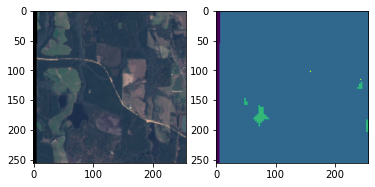

(3, 256, 256)


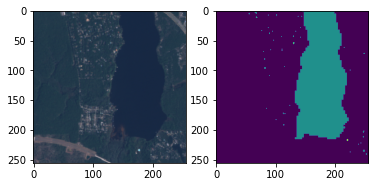

(3, 256, 256)


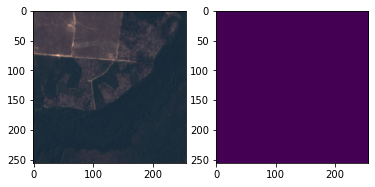

(3, 256, 256)


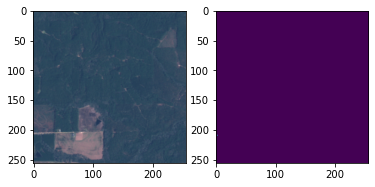

(3, 256, 256)


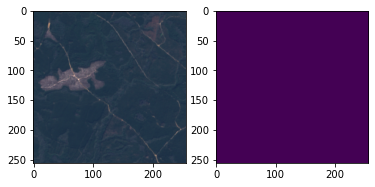

In [97]:
import matplotlib.pyplot as plt
import numpy as np

train_dl = wf_gcp_dm.train_dataloader()
test_dl = wf_gcp_dm.test_dataloader()

for i, sample in enumerate(train_dl):
    
    if i < 5:
        fig, ax = plt.subplots(1,2)
        s = sample['image'][0][[3,2,1], :, :].numpy().squeeze()
        s /= np.max(s)
        s = np.transpose(s, (1,2,0))
        ax[0].imshow(s)
        ax[1].imshow(sample['mask'][0][[0], :, :].squeeze())
        plt.show()
    else:
        break
    

### Step 3b: Setup Dataloaders (B)
    - load data from bucket to machine (load images)
    - loader handles tiling for us

In [36]:
from src.preprocess.tiling import save_tiles, WindowSize
from src.data.worldfloods.configs import CHANNELS_CONFIGURATIONS
from src.data.utils import get_files_in_bucket_directory, save_file_from_bucket

num_examples = 1

bands = CHANNELS_CONFIGURATIONS[opt.data_params.bands]
window_size = WindowSize(height=opt.data_params.window_size[0], width=opt.data_params.window_size[1])

destination_dir = Path(root).joinpath(f"datasets/demo/")

filenames = {
    "train": {},
    "val": {},
    "test": {}
}

for split in filenames.keys():
    filenames[split][opt.data_params.input_folder] = get_files_in_bucket_directory(opt.data_params.bucket_id, f"{opt.data_params.path_to_splits}/{split}/{opt.data_params.input_folder}", suffix=".tif")[:num_examples]
    filenames[split][opt.data_params.target_folder] = get_files_in_bucket_directory(opt.data_params.bucket_id, f"{opt.data_params.path_to_splits}/{split}/{opt.data_params.target_folder}", suffix=".tif")[:num_examples]
    
print(filenames)

{'train': {'S2': ['worldfloods/public/train/S2/01042016_Choctawhatchee_River_near_Bellwood_AL.tif'], 'gt': ['worldfloods/public/train/gt/01042016_Choctawhatchee_River_near_Bellwood_AL.tif']}, 'val': {'S2': ['worldfloods/public/val/S2/EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif'], 'gt': ['worldfloods/public/val/gt/EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif']}, 'test': {'S2': ['worldfloods/public/test/S2/EMSR286_08ITUANGONORTH_DEL_MONIT02_v1_observed_event_a.tif'], 'gt': ['worldfloods/public/test/gt/EMSR286_08ITUANGONORTH_DEL_MONIT02_v1_observed_event_a.tif']}}


### Download images from bucket

In [37]:
from src.data.utils import create_folder

for split in filenames.keys():
    for k in filenames[split].keys():
        create_folder(f"{destination_dir}/{split}/{k}")
        print(f'Loading files to {destination_dir}/{split}/{k}')
        for fp in filenames[split][k]:
            save_file_from_bucket(opt.data_params.bucket_id, fp, f"{destination_dir}/{split}/{k}/")
            print(f"Loaded {fp}")

Folder '/home/sambudd/ml4floods/datasets/demo/train/S2' Is Already There.
Loading files to /home/sambudd/ml4floods/datasets/demo/train/S2
Folder '/home/sambudd/ml4floods/datasets/demo/train/S2/' Is Already There.
Loaded worldfloods/public/train/S2/01042016_Choctawhatchee_River_near_Bellwood_AL.tif
Folder '/home/sambudd/ml4floods/datasets/demo/train/gt' Is Already There.
Loading files to /home/sambudd/ml4floods/datasets/demo/train/gt
Folder '/home/sambudd/ml4floods/datasets/demo/train/gt/' Is Already There.
Loaded worldfloods/public/train/gt/01042016_Choctawhatchee_River_near_Bellwood_AL.tif
Folder '/home/sambudd/ml4floods/datasets/demo/val/S2' Is Already There.
Loading files to /home/sambudd/ml4floods/datasets/demo/val/S2
Folder '/home/sambudd/ml4floods/datasets/demo/val/S2/' Is Already There.
Loaded worldfloods/public/val/S2/EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif
Folder '/home/sambudd/ml4floods/datasets/demo/val/gt' Is Already There.
Loading files to /home/sambudd/ml4floods/d

### Setup Dataloader

In [51]:
from src.data.worldfloods.lightning import WorldFloodsDataModule

In [44]:
wf_local_dm = WorldFloodsDataModule(
    input_folder=opt.data_params.input_folder,
    target_folder=opt.data_params.target_folder,
    train_transformations=train_transform,
    test_transformations=test_transform,
    data_dir='/home/sambudd/ml4floods/datasets/demo/')
wf_local_dm.setup()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


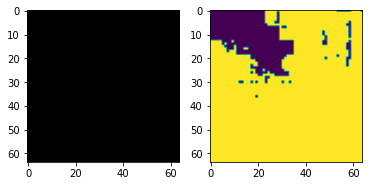

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


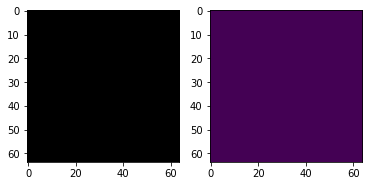

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


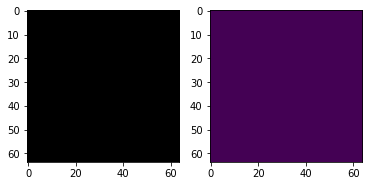

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


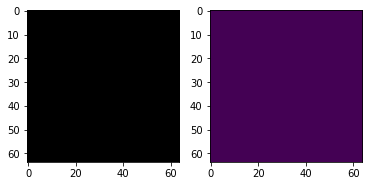

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


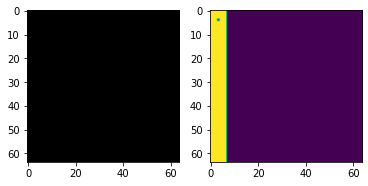

In [45]:
import matplotlib.pyplot as plt
import numpy as np

test_dl = wf_local_dm.test_dataloader()

for i, sample in enumerate(test_dl):
    
    if i < 5:
        fig, ax = plt.subplots(1,2)
        s = sample['image'][0][[1,2,3], :, :].permute(1,2,0).squeeze()
        ax[0].imshow(s)
        ax[1].imshow(sample['mask'][0][[0], :, :].squeeze())
        plt.show()
    else:
        break
    

### Step 3c: Setup Dataloaders (C)
    - load data from bucket to machine (load tiles)
    - pass tiled images to dataloader

In [46]:
for split in filenames.keys():
    for k in filenames[split].keys():
        create_folder(f"{destination_dir}_tiles/{split}/{k}")
        print(f'Loading files to {destination_dir}_tiles/{split}/{k}')
        cur_bands = bands if opt.data_params.input_folder == k else [1,]
        for fp in filenames[split][k]:            
            save_tiles(f"gs://{opt.data_params.bucket_id}/{fp}", f"{destination_dir}_tiles/{split}/{k}/", cur_bands, window_size)
            print(f'Loaded {fp}')

Folder '/home/sambudd/ml4floods/datasets/demo_tiles/train/S2' is created.
Loading files to /home/sambudd/ml4floods/datasets/demo_tiles/train/S2
Loaded worldfloods/public/train/S2/01042016_Choctawhatchee_River_near_Bellwood_AL.tif
Folder '/home/sambudd/ml4floods/datasets/demo_tiles/train/gt' is created.
Loading files to /home/sambudd/ml4floods/datasets/demo_tiles/train/gt
Loaded worldfloods/public/train/gt/01042016_Choctawhatchee_River_near_Bellwood_AL.tif
Folder '/home/sambudd/ml4floods/datasets/demo_tiles/val/S2' is created.
Loading files to /home/sambudd/ml4floods/datasets/demo_tiles/val/S2
Loaded worldfloods/public/val/S2/EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif
Folder '/home/sambudd/ml4floods/datasets/demo_tiles/val/gt' is created.
Loading files to /home/sambudd/ml4floods/datasets/demo_tiles/val/gt
Loaded worldfloods/public/val/gt/EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif
Folder '/home/sambudd/ml4floods/datasets/demo_tiles/test/S2' is created.
Loading files to /home/sa

In [52]:
wf_local_tiles_dm = WorldFloodsDataModule(
    input_folder=opt.data_params.input_folder,
    target_folder=opt.data_params.target_folder,
    train_transformations=train_transform,
    test_transformations=test_transform,
    data_dir='/home/sambudd/ml4floods/datasets/demo_tiles/'
)
wf_local_tiles_dm.setup()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


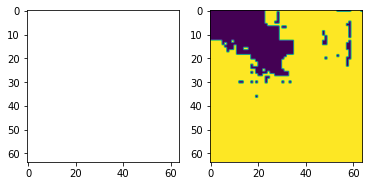

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


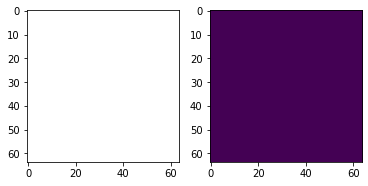

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


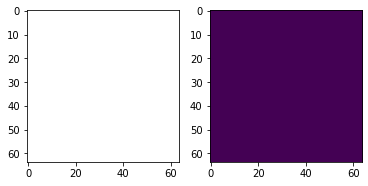

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


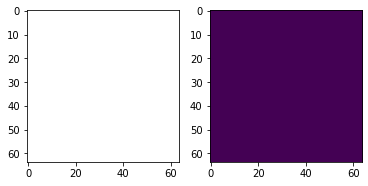

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


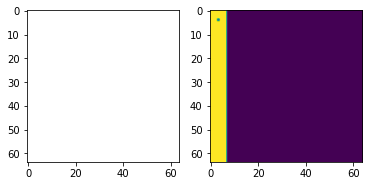

In [54]:
import matplotlib.pyplot as plt
import numpy as np

test_dl = wf_local_dm.test_dataloader()

for i, sample in enumerate(test_dl):
    
    if i < 5:
        fig, ax = plt.subplots(1,2)
        s = sample['image'][0][[1,2,3], :, :].permute(1,2,0).squeeze()
        ax[0].imshow(s)
        ax[1].imshow(sample['mask'][0][[0], :, :].squeeze())
        plt.show()
    else:
        break
    